In [1]:
import sys
# sys.path.append('/home/ssawmya-local/FM_work/SmartEM/smartem')
import sys
from pathlib import Path

# sys.path.insert(0, str(Path(__file__).parent.parent))
# import smartem

import segmenter, utils
from skimage import measure
import sys

import UNet
import UNet_

import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
import segmenter
from tqdm import tqdm
import cv2

## Set variables

In [2]:
data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
device = torch.device("cuda:5")

In [3]:
model_core = UNet.UNet(1,2)
model_us = UNet_.UNet(1,2)

# model_path = '/home/tommy-local/projects/smartem/SmartEM/pretrained_models/unet_50_1.29e-01.pth'
# model_path = '/home/ssawmya-local/FM_work/smartem_support/fusedem2mb_segformer/unet_50_1.29e-01.pth'
model_path_core = '/home/ssawmya-local/FM_work/smartem_support/fusedem2mb_segformer/em2mb_best.pth'
model_core.load_state_dict(torch.load(model_path_core))

model_path_us = '/home/ssawmya-local/FM_work/smartem_support/fusedem2mb_segformer/unet_50_1.29e-01.pth'
model_us.load_state_dict(torch.load(model_path_us))


<All keys matched successfully>

In [4]:
# model = smp.Unet(
#     encoder_name='resnet50', 
#     encoder_weights='imagenet', 
#     classes=2, 
#     activation='sigmoid',
# )

# model_path = '/home/tommy-local/projects/smartem/smartem_support/fusedem2mb/best_model_EM2MB_noslow_state.pth'

## Make Segmenter object

In [4]:
Iseg_core = segmenter.Segmenter(model_path_core, segmenter_function = measure.label, device=device)
Iseg_core.set_model(model_class=model_core)

Iseg_us = segmenter.Segmenter(model_path_us, segmenter_function = measure.label, device=device)
Iseg_us.set_model(model_class=model_us)

## Compute VI vs. Dwell Time

In [8]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []
data_hdt_vois_core = []
data_hdt_vois_us = []

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys()):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        clahe = cv2.createCLAHE(clipLimit=255 * 3.0).apply
        # print(im.shape, im.dtype)
        # im = clahe(im.astype(np.uint8))
        im = im.astype(np.uint16)*255
        hdt_labels_core = Iseg_core.get_labels(im)
        hdt_labels_us = Iseg_us.get_labels(im)
        # break


        # all dwts
        for dwt in group.keys():
            im = group[f"{dwt}/im"][()]
            # make it uint16
            im = im.astype(np.uint16)*255
            im = clahe(im)

            labels_core = Iseg_core.get_labels(im)
            labels_us = Iseg_us.get_labels(im)

            # voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
            voi_hdt_core,_,_ = pyvoi.VI(hdt_labels_core.flatten(), labels_core.flatten())
            voi_hdt_us,_,_ = pyvoi.VI(hdt_labels_us.flatten(), labels_us.flatten())
            # data_gt_vois.append(voi_gt.item()) 
            data_hdt_vois_core.append(voi_hdt_core.item())
            data_hdt_vois_us.append(voi_hdt_us.item())
            data_dwts.append(int(dwt))



# data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
data = {"Dwell Time (ns)": data_dwts, "Variation of Information from 1200ns (nats) (Core)": data_hdt_vois_core, "Variation of Information from 1200ns (nats) (MIT)": data_hdt_vois_us}
df = pd.DataFrame(data=data)

100%|██████████| 18/18 [06:23<00:00, 21.33s/it]


In [12]:
data_dwts = []
data_hdt_vois = []
data_gt_vois = []
data_hdt_vois_core_uint8_clahe = []
data_hdt_vois_core_uint8_without_clahe = []
data_hdt_vois_core_uint16_with_clahe = []
data_hdt_vois_core_uint16_without_clahe = []


with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys()):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        mask = group[f"{slowest_dwt}/mask"][()]
        gt_labels = measure.label(255 - mask)

        if gt_labels.shape[0] % 32 != 0:
            gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        clahe = cv2.createCLAHE(clipLimit=255 * 3.0).apply

        # print(im.shape, im.dtype)
        # im = clahe(im.astype(np.uint8))
        # im = im.astype(np.uint16)*255
        hdt_labels_core_uint8_without_clahe = Iseg_core.get_labels(im)
        hdt_labels_core_uint8_clahe = Iseg_core.get_labels(clahe(im.astype(np.uint8)))
        hdt_labels_core_uint16_without_clahe = Iseg_core.get_labels(im.astype(np.uint16)*255)
        hdt_labels_core_uint16_clahe = Iseg_core.get_labels(clahe(im.astype(np.uint16)*255))

        # hdt_labels_us = Iseg_us.get_labels(im)
        # break


        # all dwts
        for dwt in group.keys():
            im = group[f"{dwt}/im"][()]
            # make it uint16
            

            labels_core_uint8_without_clahe = Iseg_core.get_labels(im)
            labels_core_uint8_clahe = Iseg_core.get_labels(clahe(im.astype(np.uint8)))
            labels_core_uint16_without_clahe = Iseg_core.get_labels(im.astype(np.uint16)*255)
            labels_core_uint16_clahe = Iseg_core.get_labels(clahe(im.astype(np.uint16)*255))
            # labels_us = Iseg_us.get_labels(im)

            # voi_gt,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
            voi_hdt_core_uint8_without_clahe,_,_ = pyvoi.VI(hdt_labels_core_uint8_without_clahe.flatten(), labels_core_uint8_without_clahe.flatten())
            voi_hdt_core_uint8_clahe,_,_ = pyvoi.VI(hdt_labels_core_uint8_clahe.flatten(), labels_core_uint8_clahe.flatten())
            voi_hdt_core_uint16_without_clahe,_,_ = pyvoi.VI(hdt_labels_core_uint16_without_clahe.flatten(), labels_core_uint16_without_clahe.flatten())
            voi_hdt_core_uint16_clahe,_,_ = pyvoi.VI(hdt_labels_core_uint16_clahe.flatten(), labels_core_uint16_clahe.flatten())
            
            # data_gt_vois.append(voi_gt.item()) 
            # data_hdt_vois_core.append(voi_hdt_core.item())
            data_hdt_vois_core_uint8_without_clahe.append(voi_hdt_core_uint8_without_clahe.item())
            data_hdt_vois_core_uint8_clahe.append(voi_hdt_core_uint8_clahe.item())
            data_hdt_vois_core_uint16_without_clahe.append(voi_hdt_core_uint16_without_clahe.item())
            data_hdt_vois_core_uint16_with_clahe.append(voi_hdt_core_uint16_clahe.item())
            data_dwts.append(int(dwt))
            



# data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
# data = {"Dwell Time (ns)": data_dwts, "Variation of Information from 1200ns (nats) (Core)": data_hdt_vois_core, "Variation of Information from 1200ns (nats) (MIT)": data_hdt_vois_us}
# df = pd.DataFrame(data=data)

100%|██████████| 18/18 [12:48<00:00, 42.71s/it]


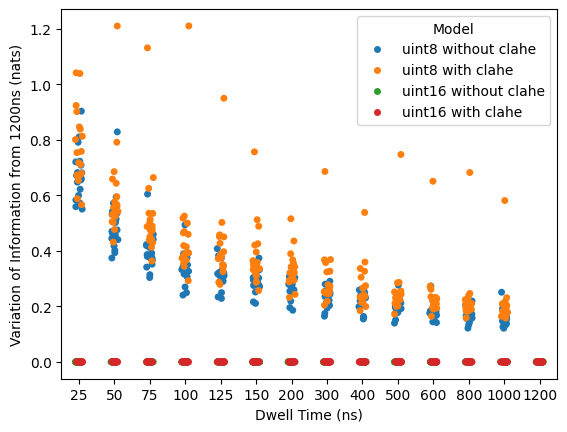

In [14]:
df = pd.DataFrame({
    "Dwell Time (ns)": data_dwts * 4,  # Duplicate dwell time for both Harvard and MIT
    "Variation of Information from 1200ns (nats)": data_hdt_vois_core_uint8_without_clahe + data_hdt_vois_core_uint8_clahe + data_hdt_vois_core_uint16_without_clahe + data_hdt_vois_core_uint16_with_clahe,
    "Model": ["uint8 without clahe"] * len(data_hdt_vois_core_uint8_without_clahe) + ["uint8 with clahe"] * len(data_hdt_vois_core_uint8_clahe) + ["uint16 without clahe"] * len(data_hdt_vois_core_uint16_without_clahe) + ["uint16 with clahe"] * len(data_hdt_vois_core_uint16_with_clahe)
})

# Create the plot with seaborn
sns.stripplot(data=df, y="Variation of Information from 1200ns (nats)", x="Dwell Time (ns)", hue="Model")

# You may also want to add a legend to differentiate the models
plt.legend(title='Model')

<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from 1200ns (nats)'>

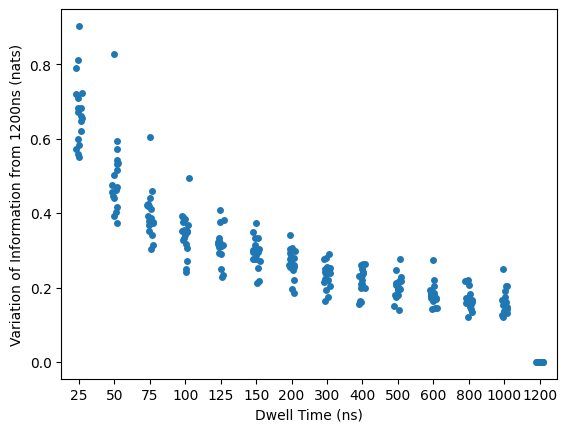

In [7]:
sns.stripplot(data=df, y="Variation of Information from 1200ns (nats)", x="Dwell Time (ns)")

<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from 1200ns (nats) (Core)'>

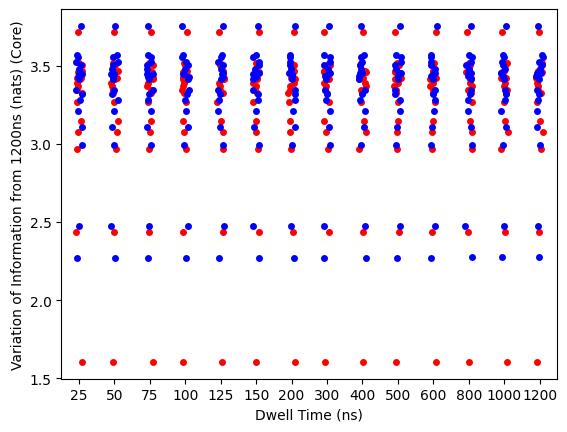

In [9]:
# plot both of the models
data = {"Dwell Time (ns)": data_dwts, "Variation of Information from 1200ns (nats) (Core)": data_hdt_vois_core, "Variation of Information from 1200ns (nats) (MIT)": data_hdt_vois_us}
df = pd.DataFrame(data=data)
sns.stripplot(data=df, y="Variation of Information from 1200ns (nats) (Core)", x="Dwell Time (ns)", color="red")
sns.stripplot(data=df, y="Variation of Information from 1200ns (nats) (MIT)", x="Dwell Time (ns)", color="blue")


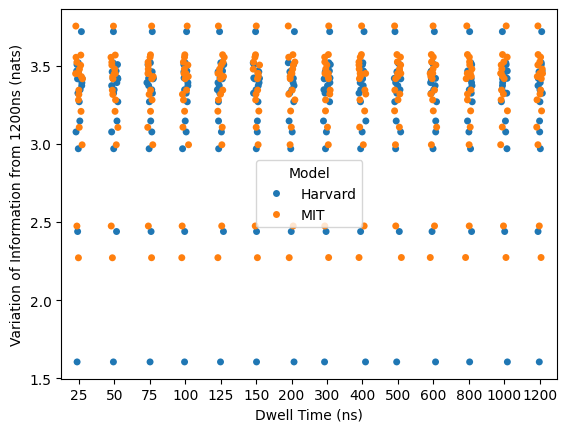

In [11]:
# Create a DataFrame
df = pd.DataFrame({
    "Dwell Time (ns)": data_dwts * 2,  # Duplicate dwell time for both Harvard and MIT
    "Variation of Information from 1200ns (nats)": data_hdt_vois_core + data_hdt_vois_us,
    "Model": ["Harvard"] * len(data_hdt_vois_core) + ["MIT"] * len(data_hdt_vois_us)
})

# Create the plot with seaborn
sns.stripplot(data=df, y="Variation of Information from 1200ns (nats)", x="Dwell Time (ns)", hue="Model")

# You may also want to add a legend to differentiate the models
plt.legend(title='Model')

# plt.yticks(np.arange(0, 1, 0.1))

# Show the plot
plt.show()

## Visualize result

In [10]:
images = {}

desired_dwts = [25, 50, 100, 400, 800, 1200]

with h5py.File(data_path, "r") as f:
    reg = list(f.keys())[3]
    group = f[reg]

    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]
    
    mask = group[f"{slowest_dwt}/mask"][()]

    gt_labels = measure.label(255 - mask)
    if gt_labels.shape[0] % 32 != 0:
        gt_labels = gt_labels[:-(gt_labels.shape[0] % 32), :]
    gt_labels_shuffled = utils.shuffle_labels(gt_labels)
    gt_labels_masked = np.ma.masked_where(gt_labels_shuffled == 0, gt_labels_shuffled)

    for dwt in desired_dwts:
        im = group[f"{dwt}/im"][()]

        _, mb_probs = Iseg.get_membranes(im, get_probs=True)
        labels = Iseg.get_labels(im)

        labels_shuffled = utils.shuffle_labels(labels)
        labels_masked = np.ma.masked_where(labels_shuffled == 0, labels_shuffled)

        voi,_,_ = pyvoi.VI(gt_labels.flatten(), labels.flatten())
        title_stem = f"{dwt}ns_VOI_{voi.item():.2f}"

        images[title_stem + "_image"] = im
        images[title_stem + "_label"] = labels_masked
        images[title_stem + "_pred"] = mb_probs


images["ground_truth_image"] = im
images["ground_truth_label"] = gt_labels_masked
images["ground_truth_pred"] = mask
images["high_dwell_time_image"] = im


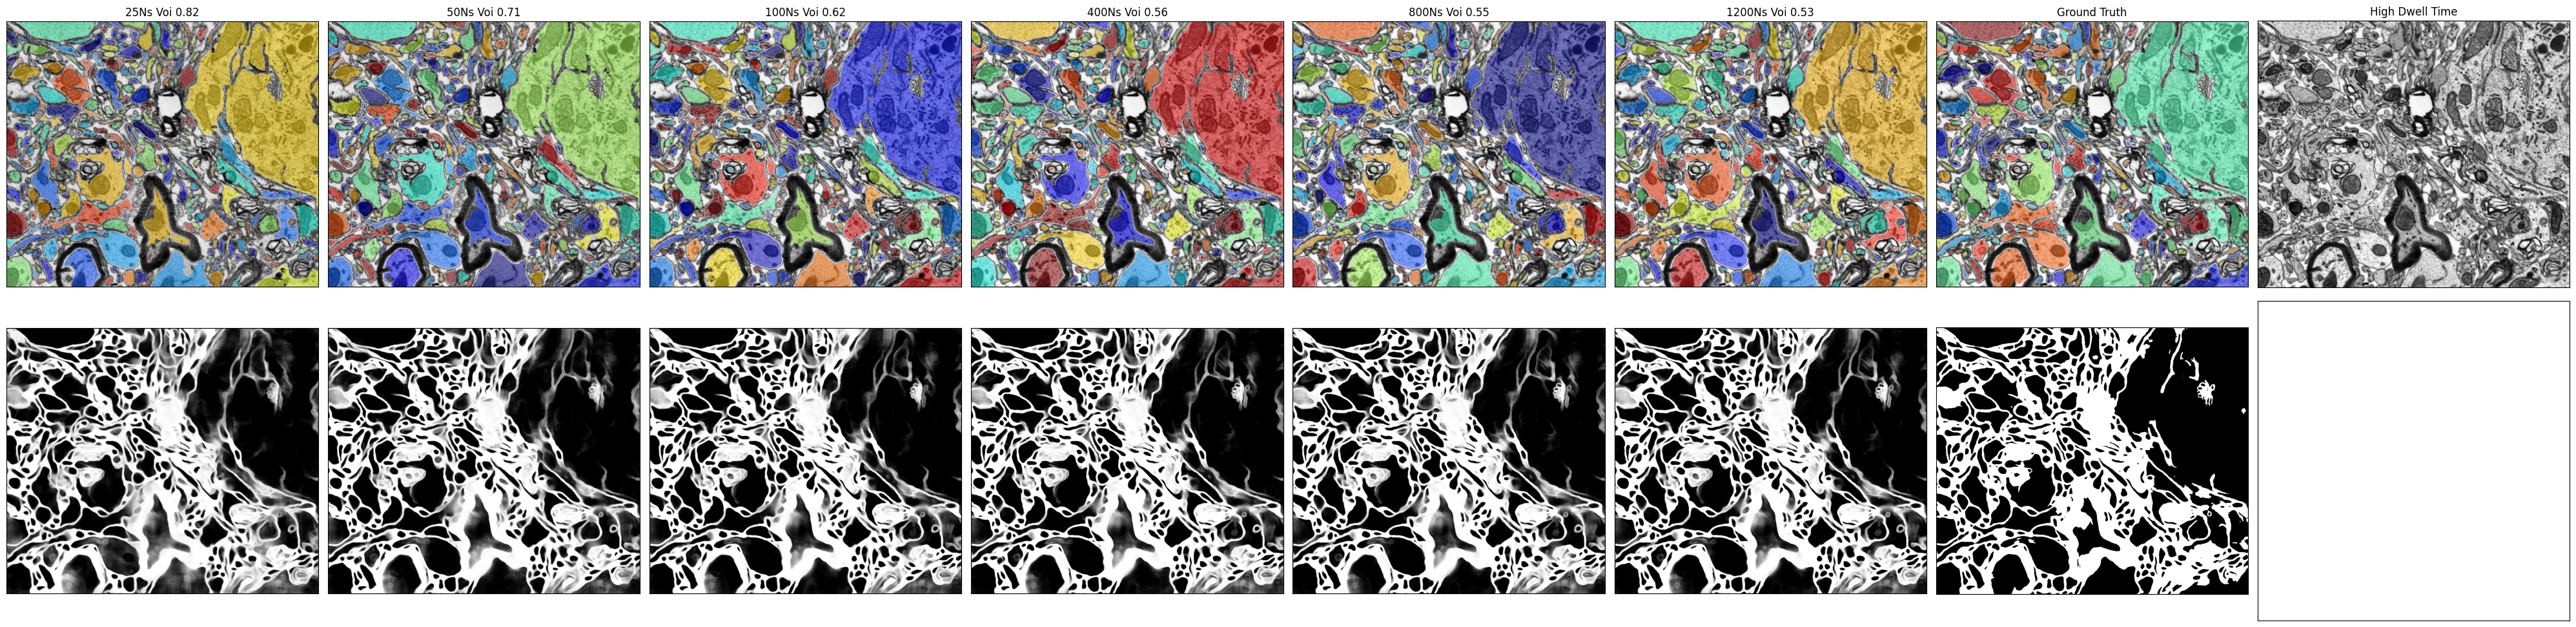

In [11]:
utils.visualize(**images)